In [5]:
import numpy as np
import scipy.stats as st
from scipy.optimize import minimize
from scipy.optimize import newton
import scipy.integrate as integrate
from scipy.interpolate import interp1d 
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [6]:
# Global setting for discretization of a derivative

bump=0.0001

# Market given implied volatilities for maturity T=1

K  = [110, 121.3, 131.5, 140.9, 151.4]
ivPrct = [14.2, 11.8, 10.3, 10.0, 10.7]
iv = [x/100.0 for x in ivPrct]

# Assume r = 0

r = 0.0;
T = 1.0;

# Beta parameter is typically fixed

beta = 0.5;
CP   = 'p';

# Forward and ATM volatility

f_0       = 131.5;
iv_atm    = iv[2];
k_atm     = K[2];

# Calibration of the Hagan parametrization
# The calibration algorithm is defined as follows: We search for two
# parameters, rho and gamma. For any set of these parameters, alpha is
# determined such that ATM we have an almost perfect fit. 

def calibrationHagan(K,t,beta,iv,iv_ATM,K_ATM,f):
    K = np.array(K)
    iv = np.array(iv)
    # x = [rho, gamma]
    f_obj = lambda x: TargetVal(beta,x[0],x[1],iv,K,iv_ATM,K_ATM,f,t)
    
    # Random initial guess

    initial = np.array([-0.8,0.4])
    pars  = minimize(f_obj,initial,method='nelder-mead', options = \
                     {'xtol': 1e-11, 'disp': False})
    #print(pars)
    
    rho_est = pars.x[0]
    gamma_est  = pars.x[1]
    parmCalibr =  {"rho":rho_est,"gamma":gamma_est}
    return parmCalibr

    # For given rho and gamma recompute alpha to ensure the ATM fit

    #[~,alpha_est] = targetVal(beta,rho_est,gamma_est,iv,K,iv_ATM,K_ATM,f,t);

def DetermineOptimalAlpha(iv_ATM, K_ATM,t,f,beta,rho,gamma):
    target      = lambda alpha: HaganImpliedVolatility(K_ATM,t,f,\
                                            alpha,beta,rho,gamma)-iv_ATM
    # Initial guess does not really matter here   

    alpha_est = newton(target,1.05,tol=0.0000001)
    return alpha_est
    
def TargetVal(beta,rho,gamma,iv,K,iv_ATM,K_ATM,f,t):
    if iv is not np.array:
        iv = np.array(iv).reshape([len(iv),1])
    
    alpha_est = DetermineOptimalAlpha(iv_ATM, K_ATM,t,f,beta,rho,gamma)
   
    # Error is defined as a difference between the market and the model

    errorVector = HaganImpliedVolatility(K,t,f,alpha_est,beta,rho,gamma) - iv
    
    # Target value is a norm of the ErrorVector

    value       = np.linalg.norm(errorVector)   
    return value

def HaganImpliedVolatility(K,T,f,alpha,beta,rho,gamma):

    #We make sure that the input is of array type

    if gamma == 0 :
        return 0.0
    if type(K) == float:
        K = np.array([K])
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    z        = gamma/alpha*np.power(f*K,(1.0-beta)/2.0)*np.log(f/K)
    x_z      = np.log((np.sqrt(1.0-2.0*rho*z+z*z)+z-rho)/(1.0-rho))
    A        = alpha/(np.power(f*K,((1.0-beta)/2.0))*(1.0+np.power(1.0-\
                      beta,2.0)/24.0*
                               np.power(np.log(f/K),2.0)+np.power((1.0-beta),\
                                        4.0)/1920.0*
                               np.power(np.log(f/K),4.0)))
    B1       = 1.0 + (np.power((1.0-beta),2.0)/24.0*alpha*alpha/(np.power((f*K),
                1-beta))+1/4*(rho*beta*gamma*alpha)/(np.power((f*K),
                             ((1.0-beta)/2.0)))+(2.0-3.0*rho*rho)/24.0*gamma*gamma)*T
    impVol   = A*(z/x_z) * B1
    B2 = 1.0 + (np.power(1.0-beta,2.0)/24.0*alpha*alpha/
                np.power(f,2.0-2.0*beta)+1.0/4.0*(rho*beta*gamma*
                alpha)/np.power(f,(1.0-beta))+(2.0-3.0*rho*rho*gamma*gamma)/24.0)*T
    
    # Special treatment for ATM strike price

    impVol[np.where(K==f)] = alpha / np.power(f,(1-beta)) * B2;
    return impVol

def BS_Call_Option_Price(CP,S_0,K,sigma,tau,r):

    # Black-Scholes call option price

    # We make sure that the input is of array type

    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    if sigma is not np.array:
        sigma = np.array(sigma).reshape([len(sigma),1])
       
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) 
        * tau) / (sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if str(CP).lower()=="c" or str(CP).lower()=="1":
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif str(CP).lower()=="p" or str(CP).lower()=="-1":
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0
    return value

def D2VdK2(x,CP,beta,alpha,rho,gamma,f_0,T,r):

    # We make sure that the input is of array type

    if x is not np.array:
        x = np.array(x).reshape([len(x),1])
    iv_f       = lambda x: HaganImpliedVolatility(x,T,f_0,alpha,beta,rho,gamma)
    optValue   = lambda x: BS_Call_Option_Price(CP,f_0,x,iv_f(x),T,r)
    D2VdK2_lambda = lambda x: (optValue(x+bump) + optValue(x-bump) - 
                               2.0 * optValue(x))/(bump*bump)
    return D2VdK2_lambda(x)

def DensityFromSABRParametric(x,CP,beta,alpha,rho,gamma,f_0,T,r):

    # We make sure that the input is of array type

    if x is not np.array:
        x = np.array(x).reshape([len(x),1])
    iv_f       = lambda x: HaganImpliedVolatility(x,T,f_0,alpha,beta,rho,gamma)
    optValue   = lambda x: BS_Call_Option_Price(CP,f_0,x,iv_f(x),T,r)
    D2VdK2_lambda = lambda x: (optValue(x+bump) + optValue(x-bump) - 
                               2.0 * optValue(x))/(bump*bump)
    return np.exp(r*T) * D2VdK2_lambda(x)

optimal parameters are: alpha=1.0965252878616292, gamma = 0.8495604163011566 and rho = -0.21319454576721492
Integral for Linear case = 0.871384769989161
Integral for Parametric case = 0.9982492879396513


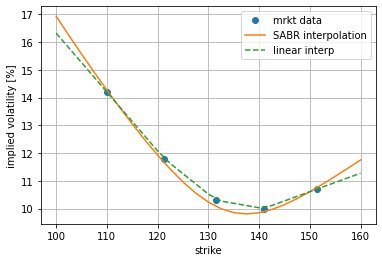

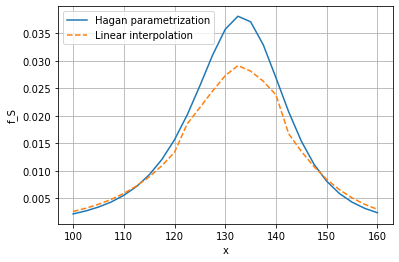

In [7]:
# Calibrate the model and show the output

calibratedParms = calibrationHagan(K,T,beta,iv,iv_atm,k_atm,f_0)

# Calibration results

plt.plot(K,ivPrct,'o')
plt.figure(1)
gamma    = calibratedParms.get('gamma')
rho      = calibratedParms.get('rho')
alpha    = DetermineOptimalAlpha(iv_atm, k_atm,T,f_0,beta,rho,gamma)[0][0]
k_grid   = np.linspace(100,160,25)
k_grid   = k_grid.reshape([len(k_grid),1])
iv_Hagan = HaganImpliedVolatility(k_grid,T,f_0,alpha,beta,rho,gamma)
plt.plot(k_grid,iv_Hagan*100.0)

# Linear interpolation results

iv_Interp = interp1d(K,iv,fill_value='extrapolate') #lambda x : np.interp(x,K,iv) 
plt.plot(k_grid,iv_Interp(k_grid)*100.0,'--')
plt.grid()
plt.xlabel('strike')
plt.ylabel('implied volatility [%]')
print('optimal parameters are: alpha={0}, gamma = {1} and rho = {2}'.format(\
      alpha,gamma,rho))
plt.legend(['mrkt data','SABR interpolation','linear interp'])

# Plot implied densities

plt.figure(2)
f_S = lambda x: DensityFromSABRParametric(x,CP,beta,alpha,rho,gamma,f_0,T,r)
plt.plot(k_grid,f_S(k_grid))
plt.grid()
plt.xlabel('x')
plt.ylabel('f_S')

optValue   = lambda x: BS_Call_Option_Price(CP,f_0,x,iv_Interp(x),T,r)
f_SLin = lambda x: (optValue(x+bump) + optValue(x-bump) - 2.0 *\
                    optValue(x))/(bump*bump)
plt.plot(k_grid,f_SLin(k_grid),'--')
plt.legend(['Hagan parametrization','Linear interpolation'])

# Integration

x= np.linspace(10,200,250)
y= f_SLin(x)
integrParmLinear = integrate.trapz(np.squeeze(y),np.squeeze(x))
print('Integral for Linear case = {0}'.format(integrParmLinear))

y= f_S(x)
integrParm = integrate.trapz(np.squeeze(y),np.squeeze(x))
print('Integral for Parametric case = {0}'.format(integrParm))
